<span style="font-size: 24px;">Binary Classification on Text Data</span>

<span style="font-size: 18px;">Question 1</span>

In [2]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
import seaborn as sns
import string
import re
from nltk.stem import WordNetLemmatizer as wnl
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans


import torch.autograd as tag

[nltk_data] Downloading package punkt to C:\Users\Sofia
[nltk_data]     Beyerlein\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Sofia
[nltk_data]     Beyerlein\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Sofia
[nltk_data]     Beyerlein\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Sofia
[nltk_data]     Beyerlein\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
#DOWNLOAD THE DATA
filepath_train = (r"C:\Users\Sofia Beyerlein\Desktop\Cornell Graduate\Applied Machine Learning\hw2\nlp-getting-started\train.csv")
filepath_test = (r'C:\Users\Sofia Beyerlein\Desktop\Cornell Graduate\Applied Machine Learning\hw2\nlp-getting-started\test.csv')

train = pd.read_csv(filepath_train)
test = pd.read_csv(filepath_test)

In [4]:
#SPLITTING THE DATA
#70% -> 5329/7613 and 30% -> 2284
training_set = train.sample(frac=0.7)
dev_set = train.drop(training_set.index)

In [5]:
def preprocess_data(df):
    words_to_remove = {'the', 'and', 'or'}
    #lowercase
    df['text'] = df['text'].apply(lambda x: x.lower())
    #remove @ and urls
    df['text'] = df['text'].apply(lambda x: re.sub(r'@\S+', '', x))
    #remove # and hashtags
    df['text'] = df['text'].apply(lambda x: re.sub(r'#\S+', '', x))
    #strip punctuation
    df['text'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    #strip the and or
    df['text'] = df['text'].apply(lambda x: ' '.join(word for word in x.split() if word not in words_to_remove))
    #lemmatize
    lemmatizer = nltk.WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    def lemmatize_text(text):
        tokens = nltk.word_tokenize(text)
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        return ' '.join(lemmatized_tokens)
    
    df['text'] = df['text'].apply(lemmatize_text)
    
    return df
    
        
preprocess_data(training_set)
preprocess_data(dev_set)

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason may allah forgive u,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,resident asked shelter place notified officer ...,1
3,6,NaN,NaN,13000 people receive evacuation order california,1
5,8,NaN,NaN,update california hwy 20 closed direction due ...,1
...,...,...,...,...,...
7601,10859,NaN,NaN,refugio oil spill may costlier bigger projecte...,1
7602,10860,NaN,NaN,siren went wasnt forney tornado warning,1
7606,10866,NaN,NaN,suicide bomber kill 15 saudi security site mos...,1
7607,10867,NaN,NaN,violent record breaking ef5 el reno oklahoma t...,1


In [6]:
M = 3
vectorizer = CountVectorizer(binary=True, min_df=M)

train_vectors = vectorizer.fit_transform(training_set['text'])
dev_vectors = vectorizer.transform(dev_set['text'])

<span style = "font-size: 18px;">Part a: Bernoulli Naive Bayes</span>

In [7]:
#functions for the bernoulli naive bayes classifier with laplace smoothing
def calculate_class_priors(y):
    num_docs = len(y)
    class_priors = np.bincount(y) / num_docs
    return class_priors

def calculate_feature_probs(X, y, alpha=1):
    num_docs, num_features = X.shape
    feature_probs = np.zeros((2, num_features))
    
    for k in range(2):
        class_docs = X[y == k]
        feature_probs[k] = (class_docs.sum(axis=0) + alpha) / (class_docs.shape[0] + 2 * alpha)
    
    return feature_probs

def predict_log_proba(X, class_priors, feature_probs):
    num_docs, num_features = X.shape
    log_probs = np.zeros((num_docs, 2))
    
    for k in range(2):
        log_prob_k = np.log(class_priors[k])
        log_prob_x_given_k = X @ np.log(feature_probs[k]) + (1 - X) @ np.log(1 - feature_probs[k])
        log_probs[:, k] = log_prob_k + log_prob_x_given_k
        
    return log_probs

def predict(X, class_priors, feature_probs):
    log_probs = predict_log_proba(X, class_priors, feature_probs)
    return np.argmax(log_probs, axis=1)

#class prior calculations
class_priors = calculate_class_priors(training_set['target'].values)

#feature probablilities with laplace smoothing calculations
feature_probs = calculate_feature_probs(train_vectors.toarray(), training_set['target'].values, alpha=1)

#dev set predictions
dev_predictions = predict(dev_vectors.toarray(), class_priors, feature_probs)

#F1 score dev set
f1 = f1_score(dev_set['target'], dev_predictions)
print(f"F1 Score: {f1}")

F1 Score: 0.7329960652051712


<span style = "font-size: 18px;">Part b: Model comparison</span>

In [8]:
#in the written report

<span style="font-size: 18px;">Question 2</span>

In [9]:
#downloading the iris data
from sklearn import datasets
iris = datasets.load_iris ( as_frame = True )
iris_df = iris.frame

file_path = r"C:\Users\Sofia Beyerlein\Desktop\Cornell Graduate\Applied Machine Learning\hw3\iris_dataset.csv"
iris_df.to_csv(file_path, index=False)

df = pd.read_csv(file_path)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [10]:
#splitting the dataset into testing and training sets
#training: a, b, c, e
#testing: d

training_set = df.sample(frac=0.8)
dev_set = df.drop(training_set.index)

<span style = "font-size: 18px;">Part a</span>

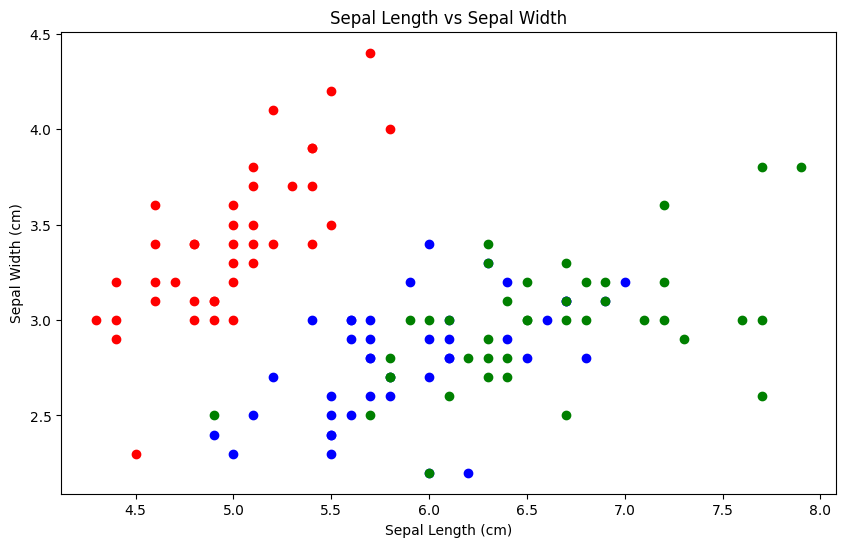

In [11]:
#using training data
#sepal length and sepal width
feature_1 = 'sepal length (cm)'
feature_2 = 'sepal width (cm)'

setosa = training_set[training_set['target'] == 0]
versicolor = training_set[training_set['target'] == 1]
virginica = training_set[training_set['target'] == 2]

plt.figure(figsize=(10, 6))
plt.scatter(setosa[feature_1], setosa[feature_2], color='red', label='Setosa')
plt.scatter(versicolor[feature_1], versicolor[feature_2], color='blue', label='Versicolor')
plt.scatter(virginica[feature_1], virginica[feature_2], color='green', label='Virginica')

plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.title('Sepal Length vs Sepal Width')

plt.show()

<span style = "font-size: 18px;">Part b</span>

In [12]:
#use training set
#n_k number of observations in class k -> num in 
#setosa, versiocolor, virginica
#N number of total observations in the data set

#these are the n_k
setosa_counts = len(setosa)
versicolor_counts = len(versicolor)
virginica_counts = len(virginica)

#N
N = len(training_set)

prior_probability = {
    "setosa" : (setosa_counts/N),
    "versicolor" : (versicolor_counts/N),
    "virginica" : (virginica_counts/N),
}

print(f"The prior probability of setosa is: {prior_probability['setosa']}")
print(f"The prior probability of setosa is: {prior_probability['versicolor']}")
print(f"The prior probability of setosa is: {prior_probability['virginica']}")

The prior probability of setosa is: 0.325
The prior probability of setosa is: 0.3416666666666667
The prior probability of setosa is: 0.3333333333333333


<span style = "font-size: 18px;">Part c</span>

In [13]:
features = iris.feature_names
target = 'target'

class_stats = {}
for class_index in training_set[target].unique():
    class_data = training_set[training_set[target] == class_index][features]
    mean_vector = class_data.mean().values
    covariance_matrix = class_data.cov().values
    
    class_stats[class_index] = {
        'mean': mean_vector,
        'covariance': covariance_matrix
    }

#Print the matrix for each class
for class_index, stats in class_stats.items():
    class_name = iris.target_names[class_index]
    print(f"Class: {class_name}")
    print(f"Mean vector {class_name}:")
    print(stats['mean'])
    print(f"Covariance matrix {class_name}:")
    print(stats['covariance'])
    print()

Class: virginica
Mean vector virginica:
[6.5825 2.975  5.5575 2.0125]
Covariance matrix virginica:
[[0.42353205 0.12108974 0.31692949 0.06535256]
 [0.12108974 0.11269231 0.09121795 0.05237179]
 [0.31692949 0.09121795 0.31430128 0.06695513]
 [0.06535256 0.05237179 0.06695513 0.08573718]]

Class: versicolor
Mean vector versicolor:
[5.91219512 2.79268293 4.24390244 1.32195122]
Covariance matrix versicolor:
[[0.26659756 0.08559146 0.17695122 0.05222561]
 [0.08559146 0.09419512 0.08707927 0.04191463]
 [0.17695122 0.08707927 0.22502439 0.0730122 ]
 [0.05222561 0.04191463 0.0730122  0.0397561 ]]

Class: setosa
Mean vector setosa:
[4.98205128 3.40769231 1.43333333 0.23589744]
Covariance matrix setosa:
[[0.13730094 0.11487854 0.01482456 0.00908232]
 [0.11487854 0.16651822 0.00684211 0.00866397]
 [0.01482456 0.00684211 0.02912281 0.00324561]
 [0.00908232 0.00866397 0.00324561 0.00762483]]



<span style = "font-size: 18px;">Part d i</span>

In [14]:
X_train = training_set[features].values
y_train = training_set[target].values
X_test = dev_set[features].values
y_test = dev_set[target].values

class_priors = {}
for class_index in np.unique(y_train):
    class_priors[class_index] = np.mean(y_train == class_index)
    
class_stats = {}
for class_index in np.unique(y_train):
    class_data = X_train[y_train == class_index]
    mean_vector = np.mean(class_data, axis=0)
    covariance_matrix = np.cov(class_data, rowvar=False)
    
    class_stats[class_index] = {
        'mean': mean_vector,
        'covariance': covariance_matrix
    }
    
def predict_class(X):
    num_classes = len(class_priors)
    num_samples = X.shape[0]
    posteriors = np.zeros((num_samples, num_classes))
    
    for class_index in range(num_classes):
        prior = class_priors[class_index]
        mean_vector = class_stats[class_index]['mean']
        covariance_matrix = class_stats[class_index]['covariance']
        
        #compute likelihood
        likelihood = multivariate_normal(mean=mean_vector, cov=covariance_matrix).pdf(X)
        
        #compute posterior probability
        posteriors[:, class_index] = likelihood * prior
    
    #predict the class with highest posterior probability
    predictions = np.argmax(posteriors, axis=1)
    return predictions

#predict the classes for the test set
y_pred = predict_class(X_test)

#print the predictions and labels
print("Predicted classes:", y_pred)
print("Actual classes:", y_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

Predicted classes: [0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
Actual classes: [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        11
  versicolor       1.00      0.89      0.94         9
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30



<span style = "font-size: 18px;">Part d ii</span>

In [15]:
#WRITTEN IN THE REPORT

<span style = "font-size: 18px;">Part e</span>

C:\Users\Sofia Beyerlein\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Sofia Beyerlein\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

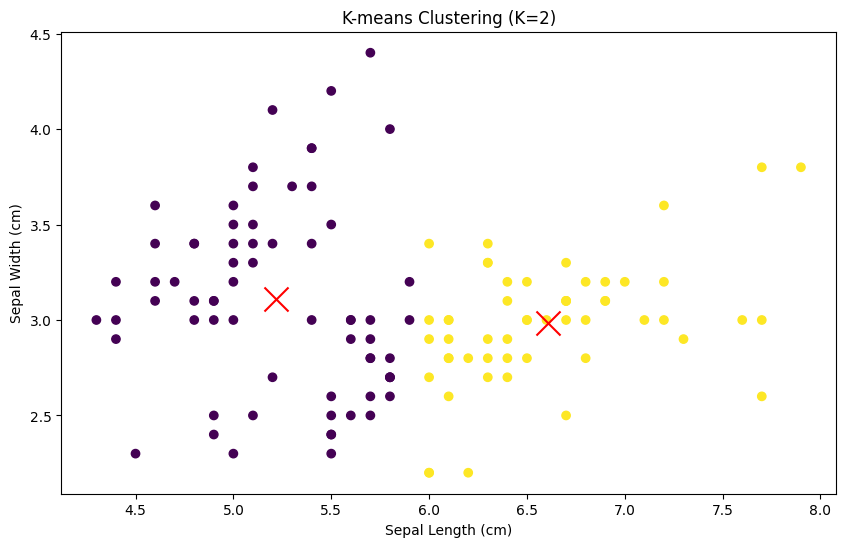

In [16]:
kmeans = KMeans(n_clusters=2, random_state=42)
training_set['cluster'] = kmeans.fit_predict(training_set[[feature_1, feature_2]])

plt.figure(figsize=(10, 6))

plt.figure(figsize=(10, 6))
plt.scatter(training_set[feature_1], training_set[feature_2], c=training_set['cluster'], cmap='viridis', marker='o')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='x')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.title('K-means Clustering (K=2)')
plt.show()